# Mining for fibroblast morphology association with survival

Figure 7 in the manuscript.

In [1]:
# 0 - imports
import matplotlib.pyplot as plt
import palettable as pal
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.colors as clr
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.plotting import add_at_risk_counts

from analysis.utils import load_pre_post_processing, robust_z_score
import analysis.cluster as clu
import analysis.visualizations as vis
from analysis.cox import CoxModel

%matplotlib inline
mpl.rcParams['figure.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'white'
pathai_colors = {
    "spacecadet":"#2D2849",
    "darkgreen":"#195866",
    "mediumgreen":"#2AA095",
    "violet":"#793EF8",
    "turquoise":"#4CEAD3",
    "raspberry":"#C5304B",
    "darkgray":"#333132",
    "lightgray":"#EEEEEE",
    "lightviolet":"#EBE2FE",
    "lightgreen":"#E1EFED",
    "_darkblue":"#173D52",
    "_lightblue":"#16B2E1",
    "_purple":"#852693",
    "_red":"#E11C29",
}

pathai_cmaps = {key: clr.LinearSegmentedColormap.from_list(key, ['#FFFFFF',pathai_colors[key]], N=256) for key in pathai_colors.keys()}

# cancer, fibroblast, lymphocyte
palette = ["orange", pathai_colors["violet"]]
scolormap = pal.scientific.sequential.Batlow_13.mpl_colormap
dcolormap = pal.scientific.diverging.Vik_18.mpl_colormap

In [2]:
cancer_nuhif_data, fibroblast_nuhif_data, lymphocyte_nuhif_data, meta_data = load_pre_post_processing(prefix="../")

In [3]:
brca_meta_names = list(meta_data["brca"].columns)
prad_meta_names = list(meta_data["prad"].columns)
luad_meta_names = list(meta_data["luad"].columns)

common_meta = set(brca_meta_names).intersection(prad_meta_names).intersection(luad_meta_names)

### Metadata preprocessing

Get the ordinal staging set up, etc.

In [4]:
brca_meta = meta_data["brca"].copy()

# staging one-hot
staging = brca_meta[["ajcc_pathologic_tumor_stage"]].replace(
    {
        "Stage X": "Unavailable", "[Discrepancy]": "Unavailable", "[Not Available]": "Unavailable",
        "Stage IIA": "Stage II", "Stage IIB": "Stage II", 
        "Stage IA": "Stage I", "Stage IB": "Stage I",
        "Stage IIIA": "Stage III", "Stage IIIC": "Stage III", "Stage IIIB": "Stage III"
    }
)
staging_dummies = pd.get_dummies(staging)

# subtype one-hot
subtypes = brca_meta[["subtype"]].replace(
    {
        "": "Unavailable",
        np.nan: "Unavailable"
    }
)
subtype_dummies = pd.get_dummies(subtypes)

# ordinal stage
ordinal_staging = staging[["ajcc_pathologic_tumor_stage"]].replace(
    {
        "Stage IV": 4, "Unavailable": np.nan,
        "Stage II": 2,
        "Stage I": 1,
        "Stage III": 3,
    },
    inplace=False
)
ordinal_staging["ordinal_staging"] = ordinal_staging.values

brca_meta = brca_meta.join(staging_dummies).join(ordinal_staging[["ordinal_staging"]]).join(subtype_dummies)

In [5]:
brca_meta.shape

(886, 26)

Finish QCing the data: this requires us to specify covariates and survival data.

In [6]:
os_vars = ["os", "os_time"]
pfs_vars = ["pfs", "pfs_time"]
covariate_vars = ['age_at_initial_pathologic_diagnosis', "ordinal_staging"]
meta = brca_meta[os_vars+pfs_vars+covariate_vars]

In [7]:
meta_trim = meta.dropna()

# reset features and metadata
feat = fibroblast_nuhif_data["brca"].copy()
feat_trim = feat.loc[list(meta_trim.index)]

feat_trim = feat_trim.apply(robust_z_score)

### Analysis

Look into survival

In [8]:
def cox_explore_all_hifs(hif_df, meta_df, event_indicator, time_indicator, covariates=[]):
    """
    Performs a continuous cox regression for each HIF.
    """

    cox_results = {}
    cox_results_complete = {}
    result_keys = ["N", "coef", "coef upper 95%", "coef lower 95%", "HR", "HR upper 95%", "HR lower 95%", "HR p"]

    km_df = hif_df.join(meta_df, how="inner")
    km_df[event_indicator] = km_df[event_indicator].astype(int)
    km_df[time_indicator] = km_df[time_indicator].astype(float)
    km_df[time_indicator] = km_df[time_indicator]/30

    coxph = CoxModel.from_datasets(
        feature_df=km_df,
        name="Exploration",
        time_col=time_indicator,
        event_col=event_indicator,
        cov_cols=covariates
    )
    
    for value in hif_df.columns:
        # loop thru hifs
        coxph.run_prognostic(value)
        N = len(hif_df)
        
        # fix table
        cox_result = coxph.cm.model.summary
        cox_result["N"] = N
        cox_result["HR"] = cox_result["exp(coef)"]
        cox_result["HR upper 95%"] = cox_result["exp(coef) upper 95%"]
        cox_result["HR lower 95%"] = cox_result["exp(coef) lower 95%"]
        cox_result["HR p"] = cox_result["p"]
        cox_result = cox_result[result_keys]
        cox_results_complete[value] = cox_result
        cox_results[value] = cox_result.loc[value]
    
    cox_results = pd.DataFrame(cox_results).transpose()
    cox_results['corrected HR p'] = multipletests(cox_results['HR p'], method = 'fdr_bh')[1]
        
    return cox_results, cox_results_complete

### PFS

In [9]:
pfs_results, pfs_results_complete = cox_explore_all_hifs(
    feat_trim, 
    meta_trim, 
    "pfs", 
    "pfs_time",
    covariates=['age_at_initial_pathologic_diagnosis'] + ["ordinal_staging"]
)

display(pfs_results)
# qqplot(pfs_results, uncorr_p_column='HR p', corr_p_column="corrected HR p")
# pfs_results.to_csv("figures/result-5/brca_caf_pfs.csv")

,N,coef,coef upper 95%,coef lower 95%,HR,HR upper 95%,HR lower 95%,HR p,corrected HR p
MEAN[FIBROBLAST_NUCLEUS_AREA]_H & E,869.0,0.222785,0.367647,0.077923,1.249552,1.444332,1.081039,0.002576,0.014202
MEAN[FIBROBLAST_NUCLEUS_CIRCULARITY]_H & E,869.0,0.237984,0.391731,0.084237,1.268689,1.479540,1.087887,0.002415,0.014202
MEAN[FIBROBLAST_NUCLEUS_ECCENTRICITY]_H & E,869.0,-0.232815,-0.079922,-0.385707,0.792300,0.923188,0.679970,0.002840,0.014202
MEAN[FIBROBLAST_NUCLEUS_MAJOR_AXIS_LENGTH]_H & E,869.0,0.159670,0.305823,0.013516,1.173123,1.357743,1.013608,0.032256,0.087972
MEAN[FIBROBLAST_NUCLEUS_MEAN_GRAYSCALE_CHANNEL_GRAY]_H & E,869.0,0.065037,0.235876,-0.105802,1.067198,1.266017,0.899603,0.455583,0.706642
MEAN[FIBROBLAST_NUCLEUS_MEAN_HSV_CHANNEL_SATURATION]_H & E,869.0,0.093603,0.270814,-0.083608,1.098124,1.311031,0.919792,0.300550,0.563531
MEAN[FIBROBLAST_NUCLEUS_MEAN_LAB_CHANNEL_A]_H & E,869.0,0.225983,0.373987,0.077980,1.253555,1.453518,1.081101,0.002766,0.014202
MEAN[FIBROBLAST_NUCLEUS_MEAN_LAB_CHANNEL_B]_H & E,869.0,-0.087324,0.092591,-0.267238,0.916380,1.097013,0.765491,0.341457,0.569095
MEAN[FIBROBLAST_NUCLEUS_MINOR_AXIS_LENGTH]_H & E,869.0,0.258563,0.414175,0.102952,1.295068,1.513121,1.108438,0.001127,0.014202
MEAN[FIBROBLAST_NUCLEUS_PERIMETER]_H & E,869.0,0.191665,0.336378,0.046953,1.211265,1.399868,1.048073,0.009435,0.029272


### OS

In [10]:
os_results, os_results_complete = cox_explore_all_hifs(
    feat_trim, 
    meta_trim, 
    "os", 
    "os_time",
    covariates=['age_at_initial_pathologic_diagnosis'] + ["ordinal_staging"]
)

display(os_results)
# os_results.to_csv("figures/result-5/brca_caf_os.csv")

,N,coef,coef upper 95%,coef lower 95%,HR,HR upper 95%,HR lower 95%,HR p,corrected HR p
MEAN[FIBROBLAST_NUCLEUS_AREA]_H & E,869.0,0.228838,0.388864,0.068812,1.257138,1.475303,1.071235,0.005067,0.038001
MEAN[FIBROBLAST_NUCLEUS_CIRCULARITY]_H & E,869.0,0.219070,0.398015,0.040125,1.244918,1.488867,1.040941,0.016420,0.061575
MEAN[FIBROBLAST_NUCLEUS_ECCENTRICITY]_H & E,869.0,-0.201185,-0.023727,-0.378644,0.817761,0.976553,0.684790,0.026282,0.078847
MEAN[FIBROBLAST_NUCLEUS_MAJOR_AXIS_LENGTH]_H & E,869.0,0.203312,0.364798,0.041826,1.225455,1.440222,1.042713,0.013602,0.061575
MEAN[FIBROBLAST_NUCLEUS_MEAN_GRAYSCALE_CHANNEL_GRAY]_H & E,869.0,-0.025003,0.173356,-0.223361,0.975307,1.189289,0.799826,0.804869,0.862360
MEAN[FIBROBLAST_NUCLEUS_MEAN_HSV_CHANNEL_SATURATION]_H & E,869.0,0.194176,0.397339,-0.008987,1.214310,1.487860,0.991053,0.061032,0.130782
MEAN[FIBROBLAST_NUCLEUS_MEAN_LAB_CHANNEL_A]_H & E,869.0,0.271059,0.439072,0.103047,1.311353,1.551266,1.108543,0.001567,0.037490
MEAN[FIBROBLAST_NUCLEUS_MEAN_LAB_CHANNEL_B]_H & E,869.0,-0.207262,0.005936,-0.420459,0.812807,1.005954,0.656745,0.056729,0.130782
MEAN[FIBROBLAST_NUCLEUS_MINOR_AXIS_LENGTH]_H & E,869.0,0.257945,0.432365,0.083525,1.294268,1.540897,1.087113,0.003749,0.037490
MEAN[FIBROBLAST_NUCLEUS_PERIMETER]_H & E,869.0,0.213678,0.372411,0.054945,1.238224,1.451229,1.056483,0.008330,0.049979


### Figure Creation

- taking the results above and generating some figures

<AxesSubplot:title={'center':'Mean Fibroblast Nucleus Area vs. OS'}, xlabel='Time (mo)', ylabel='OS'>

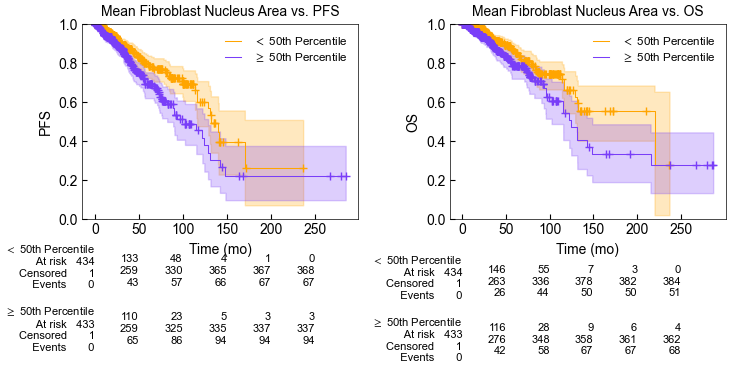

In [11]:
value = "MEAN[FIBROBLAST_NUCLEUS_AREA]_H & E"
title = "Mean Fibroblast Nucleus Area"
covariates = ['age_at_initial_pathologic_diagnosis', "ordinal_staging"]

cox_results = {}
result_keys = ["coef", "coef upper 95%", "coef lower 95%", "HR", "HR upper 95%", "HR lower 95%", "HR p"]

# drop NaNs in survival DF
survival_df = meta[["os", "os_time", "pfs", "pfs_time"] + covariates].dropna()
feature_df = feat.loc[list(survival_df.index)]

# set up os and pfs correctly
km_df = feature_df.join(survival_df, how="inner")
km_df["pfs"] = km_df["pfs"].astype(int)
km_df["pfs_time"] = km_df["pfs_time"].astype(float)
km_df["pfs_time"] = km_df["pfs_time"]/30
km_df["os"] = km_df["os"].astype(int)
km_df["os_time"] = km_df["os_time"].astype(float)
km_df["os_time"] = km_df["os_time"]/30


high_name = f"{value} | HIGH"
low_name = f"{value} | LOW"

# run prognostically split by value low/high
km_df[high_name] = (
    km_df[value].values > np.median(km_df[value].values)
) * 1

km_df[low_name] = (
    km_df[value].values <= np.median(km_df[value].values)
) * 1 

low = (km_df[low_name] == 1)
high = (km_df[high_name] == 1)

# figure
fig, axs = plt.subplots(1,2, figsize=(7.5,4.0))

ax1=axs[0]
#run KM Fitter & plot values
kmf_pfs_low = KaplanMeierFitter()
ax1 = kmf_pfs_low.fit(km_df.loc[low]["pfs_time"], km_df.loc[low]["pfs"], label="$<$ 50th Percentile").plot_survival_function(ax=ax1, show_censors=True, ci_show=True, censor_styles={'ms': 6, 'marker': '+'}, color=palette[0])

kmf_pfs_high = KaplanMeierFitter()
ax1 = kmf_pfs_high.fit(km_df.loc[high]["pfs_time"], km_df.loc[high]["pfs"], label=f"$\geq$ 50th Percentile").plot_survival_function(ax=ax1, show_censors=True, ci_show=True, censor_styles={'ms': 6, 'marker': '+'}, color=palette[1])

ax1.set_ylim([0,1])
#ax1.set_xlim([0,120])
ax1.set_xticks([0,50,100,150,200,250])
ax1.set_xlabel("Time (mo)")
ax1.set_ylabel("PFS")
ax1.legend()
ax1.set_title(f"{title} vs. PFS")

ax2=axs[1]
#run KM Fitter & plot values
kmf_os_low = KaplanMeierFitter()
ax2 = kmf_os_low.fit(km_df.loc[low]["os_time"], km_df.loc[low]["os"], label="$<$ 50th Percentile").plot_survival_function(ax=ax2, show_censors=True, ci_show=True, censor_styles={'ms': 6, 'marker': '+'}, color=palette[0])

kmf_os_high = KaplanMeierFitter()
ax2 = kmf_os_high.fit(km_df.loc[high]["os_time"], km_df.loc[high]["os"], label=f"$\geq$ 50th Percentile").plot_survival_function(ax=ax2, show_censors=True, ci_show=True, censor_styles={'ms': 6, 'marker': '+'}, color=palette[1])

ax2.set_ylim([0,1])
#ax2.set_xlim([0,120])
ax2.set_xticks([0,50,100,150,200,250])
ax2.set_xlabel("Time (mo)")
ax2.set_ylabel("OS")
ax2.legend()
ax2.set_title(f"{title} vs. OS")


add_at_risk_counts(kmf_pfs_low, kmf_pfs_high, size=8, ax=ax1)
add_at_risk_counts(kmf_os_low, kmf_os_high, size=8, ax=ax2)

# shows up crooked for some reason!
# plt.savefig("figures/result-5/survival.svg")

In [12]:
cox2_df = km_df.copy()

coxph2 = CoxModel.from_datasets(
    feature_df=cox2_df,
    name="Exploration",
    time_col="pfs_time",
    event_col="pfs",
    cov_cols=covariates
)

# run prognostic with age as a covariate
coxph2.run_prognostic(high_name)

# fix table
cox_result = coxph2.cm.model.summary
cox_result["HR"] = cox_result["exp(coef)"]
cox_result["HR upper 95%"] = cox_result["exp(coef) upper 95%"]
cox_result["HR lower 95%"] = cox_result["exp(coef) lower 95%"]
cox_result["HR p"] = cox_result["p"]
cox_result = cox_result[result_keys]

print("PFS:")
display(cox_result) 

coxph2 = CoxModel.from_datasets(
    feature_df=cox2_df,
    name="Exploration",
    time_col="os_time",
    event_col="os",
    cov_cols=covariates
)

# run prognostic with age as a covariate
coxph2.run_prognostic(high_name)

# fix table
cox_result = coxph2.cm.model.summary
cox_result["HR"] = cox_result["exp(coef)"]
cox_result["HR upper 95%"] = cox_result["exp(coef) upper 95%"]
cox_result["HR lower 95%"] = cox_result["exp(coef) lower 95%"]
cox_result["HR p"] = cox_result["p"]
cox_result = cox_result[result_keys]

print("OS:")
display(cox_result) 

PFS:


,coef,coef upper 95%,coef lower 95%,HR,HR upper 95%,HR lower 95%,HR p
covariate,,,,,,,
MEAN[FIBROBLAST_NUCLEUS_AREA]_H & E | HIGH,0.593643,0.910042,0.277243,1.810572,2.484428,1.319487,2.356531e-04
age_at_initial_pathologic_diagnosis,0.029938,0.042028,0.017848,1.030390,1.042923,1.018008,1.213939e-06
ordinal_staging,0.812280,1.023298,0.601262,2.253039,2.782355,1.824421,4.537467e-14


OS:


,coef,coef upper 95%,coef lower 95%,HR,HR upper 95%,HR lower 95%,HR p
covariate,,,,,,,
MEAN[FIBROBLAST_NUCLEUS_AREA]_H & E | HIGH,0.572619,0.940622,0.204617,1.772904,2.561573,1.227054,2.290382e-03
age_at_initial_pathologic_diagnosis,0.040407,0.054699,0.026114,1.041234,1.056222,1.026458,3.005303e-08
ordinal_staging,0.865249,1.097829,0.632669,2.375597,2.997650,1.882628,3.065395e-13


### Feature Correlations


In [13]:
corr_hif_names = [
    'MEAN[FIBROBLAST_NUCLEUS_AREA]_H & E', 
    'MEAN[FIBROBLAST_NUCLEUS_MAJOR_AXIS_LENGTH]_H & E',
    'MEAN[FIBROBLAST_NUCLEUS_MINOR_AXIS_LENGTH]_H & E', 
    'MEAN[FIBROBLAST_NUCLEUS_PERIMETER]_H & E'
]

corr_feat = fibroblast_nuhif_data["brca"].copy()[corr_hif_names]

In [14]:
corrvals = np.tril(corr_feat.corr().values, -1).flatten()
corrvals = corrvals[corrvals != 0]
print(corrvals.mean())

0.9023220636551911
